## Binary cell-type classification on PBMC-33K dataset

In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import *
import umap

### Introduction: PBMCs

PBMCs include lymphocytes (T cells, B cells, and NK cells), monocytes, and dendritic cells. In humans, the frequencies of these populations vary across individuals, but typically, lymphocytes are in the range of 70–90 %, monocytes from 10 to 20 %, while dendritic cells are rare, accounting for only 1–2 %.

**In this tutorial we will work PBMC-33K dataset that is filtered to two cell types: Tcm/Naive cytotoxic T cells and Tcm/Naive helper T cells.**

[List of markers for T-cells](https://www.biocompare.com/Editorial-Articles/569888-A-Guide-to-T-Cell-Markers/)

<img src="figures/Cellular-Compsition-of-Whole-Blood.jpeg" width=600 height=600 />

[image-source](https://bioscience.lonza.com/lonza_bs/DE/en/pbmcs-the-one-stop-immune-cells-shop)

In [ ]:
### reminder: the notebook kernel you used in day1 should work fine for today as well. 
# otherwise 
# conda activate <environment>
# python -m ipykernel install --user --name=krml

### 1. Load dataset 

In [10]:
## Let's load the filtered dataset as numpy object
X = np.load('../data/pbmc_33k/33k_binary_cytoT_helperT.npy',  mmap_mode='r')      
y = np.load('../data/pbmc_33k/33k_binary_cytoT_helperT_lbl.npy', mmap_mode='r')
gene_names = pd.read_csv('../data/pbmc_33k/33k_binary_gene_ids.csv')
target_names = ['Tcm/Naive cytotoxic T cells', 'Tcm/Naive helper T cells']

In [11]:
X.shape

(5184, 32738)

In [12]:
# making sure the number of samples and labels match 
assert X.shape[0] == len(y)

In [13]:
# making sure the number of genes and gene ids match 
assert X.shape[1] == len(gene_names)

In [14]:
## a glimpse into scrna-seq counts data 
X

memmap([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### 2. Feature selection

**Question:** Can you suggest a simple feature selection method to start with?

<details>

<summary>Answer</summary>
We can start with removing uninformative genes.<br><br>
    
    
    
```python
mask = np.where((np.sum(X > 0, axis = 0)))[0]
X = X[:, mask]

## let's see the new shape of the data 
X.shape
```
   
</details>

In [15]:
### please fill in with your answer


**Question:** Do we need to apply the same selection mask in another variable? 

<details>

<summary>Answer</summary>
    
```python
## use the same mask on gene ids as well
gene_names = gene_names.iloc[mask]
```
    
<br> 
    
 ```python
##don't forget to check whether the shape of the data and the number of remaining genes still match.
assert X.shape[1] == len(gene_names)
```   
   
</details>


In [16]:
### please fill in with your answer


In [18]:
from sklearn.preprocessing import StandardScaler
X_sc = StandardScaler().fit_transform(X)
X_sc

array([[-0.02406323, -0.01389023, -0.02406323, ..., -0.05014001,
        -0.16842622, -0.16117167],
       [-0.02406323, -0.01389023, -0.02406323, ..., -0.05014001,
         5.9373183 , -0.16117167],
       [-0.02406323, -0.01389023, -0.02406323, ..., -0.05014001,
        -0.16842622, -0.16117167],
       ...,
       [-0.02406323, -0.01389023, -0.02406323, ..., -0.05014001,
        -0.16842622, -0.16117167],
       [-0.02406323, -0.01389023, -0.02406323, ..., -0.05014001,
        -0.16842622,  5.9374704 ],
       [-0.02406323, -0.01389023, -0.02406323, ..., -0.05014001,
        -0.16842622,  5.9374704 ]], dtype=float32)

### 3. Feature extraction & 2D visualization

In [25]:
## Let's use PCA to reduce dimensionality even lower 
X_sc_pca = PCA(n_components=50, random_state=42).fit_transform(X_sc)

In [26]:
X_sc_umap = (umap.UMAP()).fit_transform(X_sc_pca)

#### let's observe how our data looks like 

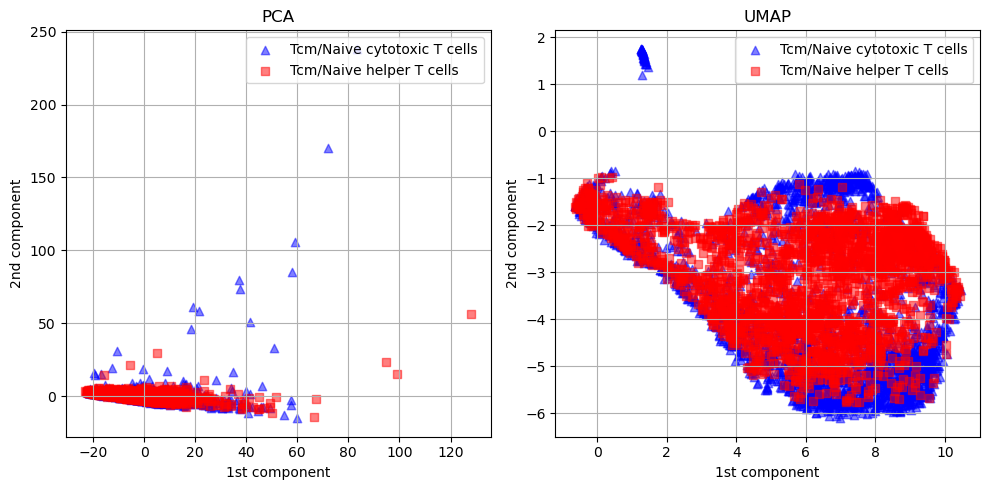

In [27]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

target_classes = range(0, 2)
colors = ("blue", "red")
markers = ("^", "s")

for target_class, color, marker in zip(target_classes, colors, markers):
    ax1.scatter(
        x=X_sc_pca[y == target_class, 0],
        y=X_sc_pca[y == target_class, 1],
        color=color,
        label=f"{target_names[target_class]}",
        alpha=0.5,
        marker=marker,
    )

    ax2.scatter(
        x=X_sc_umap[y == target_class, 0],
        y=X_sc_umap[y == target_class, 1],
        color=color,
        label=f"{target_names[target_class]}",
        alpha=0.5,
        marker=marker,
    )

ax1.set_title("PCA")
ax2.set_title("UMAP")

for ax in (ax1, ax2):
    ax.set_xlabel("1st component")
    ax.set_ylabel("2nd component")
    ax.legend(loc="upper right")
    ax.grid()

_ = plt.tight_layout()

### 4. Preparing the data for model training 

**Question:** What will be the first step to follow before starting training our model? <br> **Hint:** ``` from sklearn.model_selection ```

<details>

<summary>Answer</summary>
We need to separete the dataset into training and test sets for proper modeling. <br><br>
    
```python
## common ratios are 70%-30% or 80%-20%
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
                        X, y, test_size=0.30, random_state=42)


## let's check the shape of training data 
x_train.shape

```
   
</details>


In [28]:
### please fill in with your answer



### 4. Supervised learning: initializing the classifier 

In [29]:
## classifier needs training data and labels to learn a mapping between them
clf = LogisticRegression(random_state=3).fit(x_train, y_train)

In [30]:
## let's now ask the classifier to predict for test data 
pred_y = clf.predict(x_test)
pred_prob = clf.predict_proba(x_test)[::,1]

### 5. Evaluating the classifier performance 

**Question:** How do we interpret the confusion matrix display below? Can you name a few evalution metrics we can use for this task? See ```sklearn.metrics``` for potential metrics.

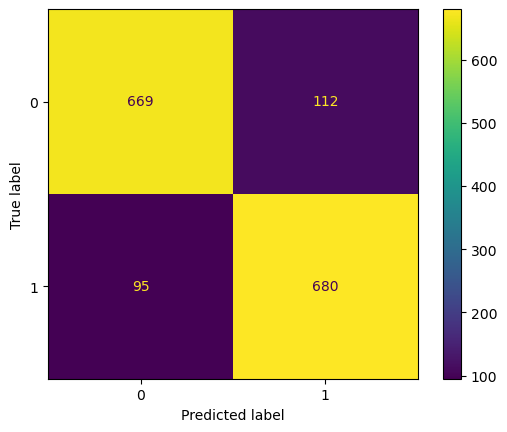

In [31]:
ConfusionMatrixDisplay.from_predictions(y_test, pred_y)

<details>

<summary>Answer</summary>
Since this is a classification problem, we can use accuracy, AUROC and mroe. 
    
```python
### Accuracy 
np.round(accuracy_score(y_test, pred_y), 3)


# Area Under Roc Curve 
fpr, tpr, _ = roc_curve(y_test,  pred_prob)
auc = roc_auc_score(y_test, pred_prob)
plt.plot(fpr,tpr,label=f'AUC={np.round(auc,3)}')
plt.title('AUROC plot')
plt.legend(loc=4)


```
   
</details>

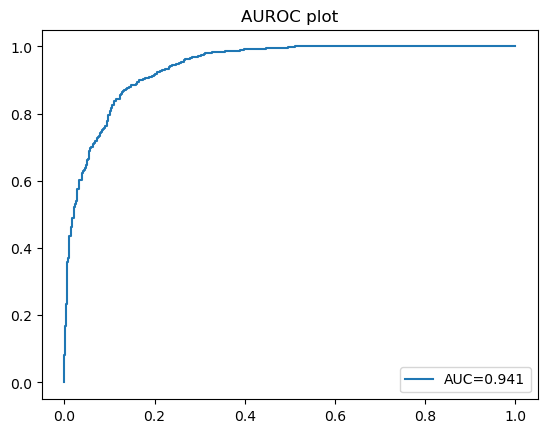

In [32]:
### please fill in with your answer


### 5. Investigating coefficients

In [33]:
least_informative_genes = np.argsort(np.abs(clf.coef_))[0][:10]
most_informative_genes = np.argsort(np.abs(clf.coef_))[0][-10:]

In [34]:
gene_names.iloc[most_informative_genes]

,Unnamed: 0,gene_ids
29201,TSHZ2,ENSG00000182463
30428,HCST,ENSG00000126264
14094,CD40LG,ENSG00000102245
1902,S100A11,ENSG00000163191
20559,NELL2,ENSG00000184613
32694,S100B,ENSG00000160307
20281,RP11-291B21.2,ENSG00000256039
19179,CTSW,ENSG00000172543
4064,CD8A,ENSG00000153563
4065,CD8B,ENSG00000172116


In [35]:
## let's filter the data to the most & least informative 10 genes separetely 
least_X = X_sc[:, least_informative_genes].copy()
most_X = X_sc[:, most_informative_genes].copy()
most_X.shape

(5184, 10)

#### 5.1 Let's use the least informative genes for training the classifier 

In [36]:
lx_train, lx_test, ly_train, ly_test = train_test_split(
                        least_X, y, test_size=0.30, random_state=42)

In [38]:
lclf = LogisticRegression(random_state=3).fit(lx_train, ly_train)
lpred_y = lclf.predict(lx_test)
lpred_prob = lclf.predict_proba(lx_test)[::,1]
np.round(accuracy_score(ly_test, lpred_y), 3)

0.498

#### 5.2 Let's use the most informative genes for training the classifier 

<details>

<summary>Answer</summary>
    
```python
mx_train, mx_test, my_train, my_test = train_test_split(
                        most_X, y, test_size=0.30, random_state=42)

mclf = LogisticRegression(random_state=3).fit(mx_train, my_train)
mpred_y = mclf.predict(mx_test)
mpred_prob = mclf.predict_proba(mx_test)[::,1]
print(np.round(accuracy_score(my_test, mpred_y), 3))


```
   
</details>

In [40]:
### please fill in with your answer



**Question:** Please plot AUROC curves of these two predictions in the same plot. 

<details>

<summary>Answer</summary>

```python

# Area Under Roc Curve 
mfpr, mtpr, _ = roc_curve(y_test,  mpred_prob)
lfpr, ltpr, _ = roc_curve(y_test,  lpred_prob)
plt.plot(mfpr,mtpr,label='most')
plt.plot(lfpr,ltpr,label='least')
plt.title('AUROC plot')
plt.legend(loc=4)


```
   
</details>

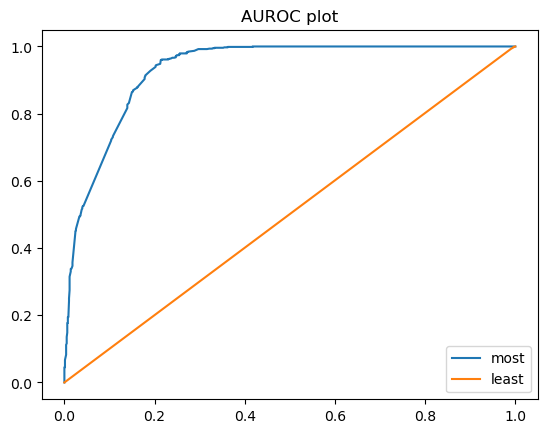

In [41]:
### please fill in with your answer



### 5.3 Let's now plot PCA and UMAP again using only most informative genes

<details>

<summary>Answer</summary>

```python

most_X_pca = PCA(n_components=5, random_state=42).fit_transform(most_X)
most_X_umap = (umap.UMAP()).fit_transform(most_X)

```
   
</details>

In [42]:
### please fill in with your answer


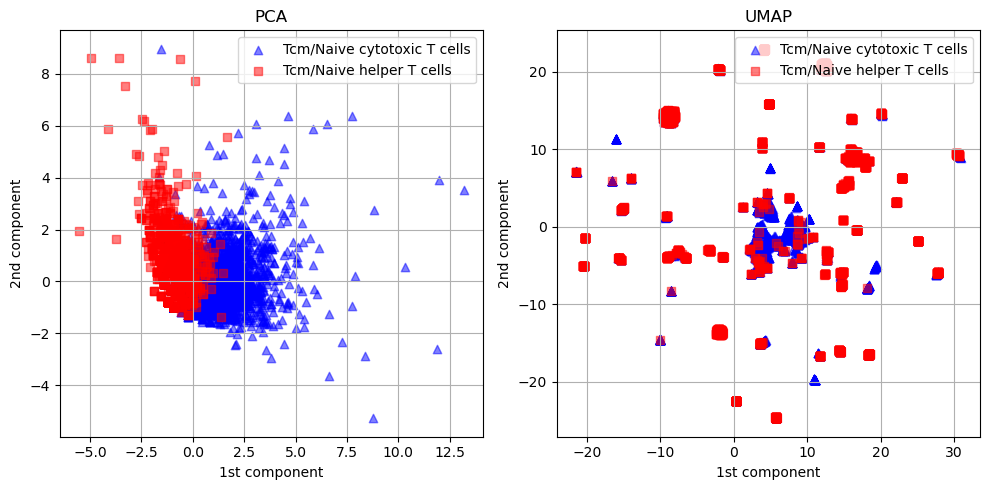

In [43]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

target_classes = range(0, 2)
colors = ("blue", "red")
markers = ("^", "s")

for target_class, color, marker in zip(target_classes, colors, markers):
    ax1.scatter(
        x=most_X_pca[y == target_class, 0],
        y=most_X_pca[y == target_class, 1],
        color=color,
        label=f"{target_names[target_class]}",
        alpha=0.5,
        marker=marker,
    )

    ax2.scatter(
        x=most_X_umap[y == target_class, 0],
        y=most_X_umap[y == target_class, 1],
        color=color,
        label=f"{target_names[target_class]}",
        alpha=0.5,
        marker=marker,
    )

ax1.set_title("PCA")
ax2.set_title("UMAP")

for ax in (ax1, ax2):
    ax.set_xlabel("1st component")
    ax.set_ylabel("2nd component")
    ax.legend(loc="upper right")
    ax.grid()

_ = plt.tight_layout()

In [ ]:
### See you in the next notebook :) 